# BÀI TUẦN 6

- NGO HONG THONG
- 22649011

### Cài đặt thư viện

In [32]:
!pip install torch torchvision torchtext transformers datasets seaborn -q
import warnings
warnings.filterwarnings('ignore')


In [33]:
# import kagglehub
# import shutil
# import os

# # Download latest version (tải dataset)
# path = kagglehub.dataset_download("atifaliak/youtube-comments-dataset")
# print("Dataset được tải về:", path)

# # Đường dẫn đích (folder data trong tk1)
# dest_path = os.path.abspath("./data/atifaliak/youtube-comments-dataset")

# # Copy toàn bộ dataset về folder data
# if os.path.exists(dest_path):
#     shutil.rmtree(dest_path)  # Xóa nếu đã có dữ liệu cũ
# shutil.copytree(path, dest_path)

# print("Dataset đã được lưu vào:", dest_path)

### a) Load và trực quan hóa dữ liệu

📄 5 dòng đầu:


,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive



🔍 Thông tin:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18408 entries, 0 to 18407
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comment    18364 non-null  object
 1   Sentiment  18408 non-null  object
dtypes: object(2)
memory usage: 287.8+ KB
None


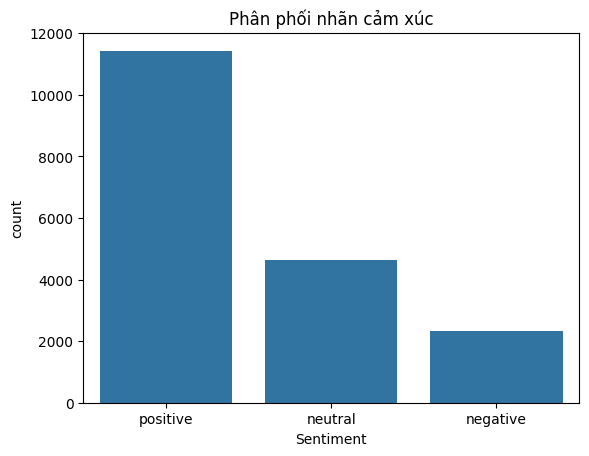

Tập huấn luyện: 14726, Tập kiểm thử: 3682


In [34]:
# %%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Dataset nguồn từ Kaggle
df = pd.read_csv("./data/atifaliak/youtube-comments-dataset/YoutubeCommentsDataSet.csv")

print("📄 5 dòng đầu:")
display(df.head())

# Kiểm tra dữ liệu
print("\n🔍 Thông tin:")
print(df.info())

# Kiểm tra phân phối nhãn
sns.countplot(data=df, x='Sentiment', order=df['Sentiment'].value_counts().index)
plt.title("Phân phối nhãn cảm xúc")
plt.show()

# Chia tập huấn luyện / kiểm thử
X_train, X_test, y_train, y_test = train_test_split(
    df['Comment'], df['Sentiment'], test_size=0.2, random_state=42, stratify=df['Sentiment']
)
print(f"Tập huấn luyện: {len(X_train)}, Tập kiểm thử: {len(X_test)}")


### Mã hóa nhãn và chuẩn bị DataLoader

In [35]:
# %%
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import re
from collections import Counter

# Mã hóa nhãn (0,1,2)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
print("Mapping nhãn:", dict(zip(le.classes_, le.transform(le.classes_))))

# Simple tokenizer (avoid torchtext binary compatibility issues)
_token_pattern = re.compile(r"\b\w+\b")

def tokenizer(text):
    if not isinstance(text, str):
        return []
    return _token_pattern.findall(text.lower())

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

# Build vocab from training data (reserve index 0 for <unk>)
counter = Counter()
for tokens in yield_tokens(X_train):
    counter.update(tokens)
vocab_list = ['<unk>'] + [w for w, _ in counter.most_common()]
vocab = {w: i for i, w in enumerate(vocab_list)}

def text_pipeline(x):
    toks = tokenizer(x)
    if len(toks) == 0:
        return [0]  # return <unk> if empty
    return [vocab.get(tok, 0) for tok in toks]

def label_pipeline(y):
    return int(y)

class CommentDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        token_ids = text_pipeline(self.texts.iloc[idx])
        if len(token_ids) == 0:
            token_ids = [0]
        return torch.tensor(token_ids, dtype=torch.long), \
               torch.tensor(int(self.labels[idx]), dtype=torch.long)

def collate_batch(batch):
    text_list, label_list = [], []
    for (text, label) in batch:
        # ensure every text is a 1D tensor
        if text.numel() == 0:
            text = torch.tensor([0], dtype=torch.long)
        text_list.append(text)
        label_list.append(int(label))
    text_list = pad_sequence(text_list, batch_first=True, padding_value=0)
    label_list = torch.tensor(label_list, dtype=torch.long)
    return text_list, label_list

train_ds = CommentDataset(X_train, y_train_enc)
test_ds = CommentDataset(X_test, y_test_enc)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_batch)
test_dl = DataLoader(test_ds, batch_size=4, collate_fn=collate_batch)


Mapping nhãn: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}


### Xây dựng và huấn luyện mô hình RNN (LSTM)

In [36]:
# %%
import torch.nn as nn
from tqdm import tqdm

class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        _, (h, _) = self.lstm(x)
        out = self.fc(h[-1])
        return self.softmax(out)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SentimentRNN(len(vocab), embed_dim=100, hidden_dim=128, num_classes=len(le.classes_)).to(device)

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Huấn luyện
EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    # progress bar cho từng batch
    progress_bar = tqdm(train_dl, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)

    for X_batch, y_batch in progress_bar:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"batch_loss": f"{loss.item():.4f}"})  # hiển thị loss từng batch

    avg_loss = total_loss / len(train_dl)

    # Hiển thị log chi tiết sau mỗi epoch
    if torch.cuda.is_available():
        mem = torch.cuda.memory_allocated(device) / (1024 ** 2)
        print(f"Epoch {epoch+1:02d}/{EPOCHS} | Loss: {avg_loss:.4f} | GPU Mem: {mem:.1f} MB")
    else:
        print(f"Epoch {epoch+1:02d}/{EPOCHS} | Loss: {avg_loss:.4f}")


Epoch 1/20:   0%|          | 0/3682 [00:00<?, ?it/s, batch_loss=1.1339]

Epoch 01/20 | Loss: 0.8106 | GPU Mem: 477.6 MB


Epoch 02/20 | Loss: 0.5986 | GPU Mem: 477.6 MB


Epoch 03/20 | Loss: 0.4412 | GPU Mem: 477.6 MB


Epoch 04/20 | Loss: 0.2940 | GPU Mem: 477.6 MB


Epoch 05/20 | Loss: 0.1737 | GPU Mem: 477.6 MB


Epoch 06/20 | Loss: 0.0930 | GPU Mem: 477.6 MB


Epoch 07/20 | Loss: 0.0580 | GPU Mem: 477.6 MB


Epoch 08/20 | Loss: 0.0335 | GPU Mem: 477.6 MB


Epoch 09/20 | Loss: 0.0278 | GPU Mem: 477.6 MB


Epoch 10/20 | Loss: 0.0230 | GPU Mem: 477.6 MB


Epoch 11/20 | Loss: 0.0154 | GPU Mem: 477.6 MB


Epoch 12/20 | Loss: 0.0161 | GPU Mem: 477.6 MB


Epoch 13/20 | Loss: 0.0123 | GPU Mem: 477.6 MB


Epoch 14/20 | Loss: 0.0160 | GPU Mem: 477.6 MB


Epoch 15/20 | Loss: 0.0133 | GPU Mem: 477.6 MB


Epoch 16/20 | Loss: 0.0087 | GPU Mem: 477.6 MB


Epoch 17/20 | Loss: 0.0067 | GPU Mem: 477.6 MB


Epoch 18/20 | Loss: 0.0075 | GPU Mem: 477.6 MB


Epoch 19/20 | Loss: 0.0078 | GPU Mem: 477.6 MB


Epoch 20/20 | Loss: 0.0057 | GPU Mem: 477.6 MB



📊 Báo cáo phân loại:
              precision    recall  f1-score   support

    negative       0.47      0.39      0.42       468
     neutral       0.58      0.54      0.56       928
    positive       0.82      0.87      0.84      2286

    accuracy                           0.73      3682
   macro avg       0.62      0.60      0.61      3682
weighted avg       0.71      0.73      0.72      3682

Accuracy: 0.7256925583921782


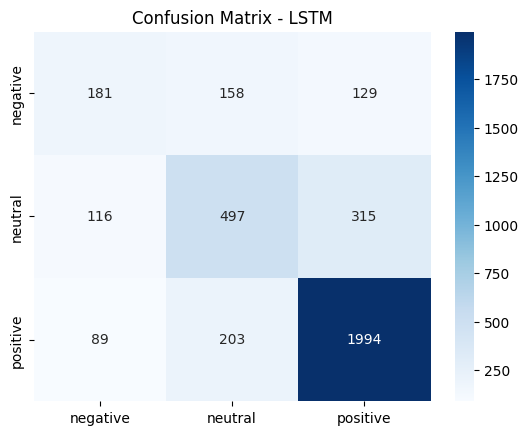

In [37]:
# %%
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

model.eval()
y_true_rnn, y_pred_rnn = [], []

with torch.no_grad():
    for X_batch, y_batch in test_dl:
        X_batch = X_batch.to(device)
        preds = model(X_batch).cpu().numpy()
        y_pred_rnn.extend(np.argmax(preds, axis=1))
        y_true_rnn.extend(y_batch.numpy())

print("\n📊 Báo cáo phân loại:")
print(classification_report(y_true_rnn, y_pred_rnn, target_names=le.classes_))
print("Accuracy:", accuracy_score(y_true_rnn, y_pred_rnn))

sns.heatmap(confusion_matrix(y_true_rnn, y_pred_rnn), annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - LSTM")
plt.show()


### Fine-tuning Transformer (BERT)

In [38]:
# # %% 
# !pip uninstall -y accelerate transformers
# !pip install -U "accelerate>=0.26.0" "transformers[torch]" datasets
# !pip install -U "transformers>=4.37.0" "accelerate>=0.26.0" datasets -q

✅ Running on: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 - Average Loss: 0.4509


Epoch 2/5 - Average Loss: 0.2557


Epoch 3/5 - Average Loss: 0.1379


Epoch 4/5 - Average Loss: 0.0904


Epoch 5/5 - Average Loss: 0.0585

📊 Kết quả mô hình BERT:
Accuracy: 0.8430785966820777
              precision    recall  f1-score   support

    negative       0.84      0.65      0.73       468
     neutral       0.71      0.73      0.72       926
    positive       0.90      0.93      0.91      2283

    accuracy                           0.84      3677
   macro avg       0.82      0.77      0.79      3677
weighted avg       0.84      0.84      0.84      3677



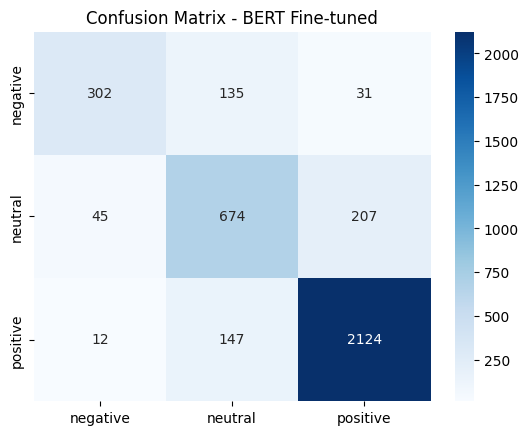

In [39]:
# %% BERT FINE-TUNING MANUAL TRAIN LOOP
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ========== CẤU HÌNH ==========
os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Running on:", device)

# ========== TOKENIZE ==========
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Filter texts and corresponding labels (keep alignment)
train_texts = []
train_labels_filtered = []
for text, label in zip(X_train.tolist(), y_train_enc):
    if isinstance(text, str):
        train_texts.append(text)
        train_labels_filtered.append(int(label))

test_texts = []
test_labels_filtered = []
for text, label in zip(X_test.tolist(), y_test_enc):
    if isinstance(text, str):
        test_texts.append(text)
        test_labels_filtered.append(int(label))

# Tokenize and return PyTorch tensors
max_length = 128
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length, return_tensors="pt")

# Build TensorDatasets from encodings and labels
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    torch.tensor(train_labels_filtered, dtype=torch.long)
)
test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    torch.tensor(test_labels_filtered, dtype=torch.long)
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4)

# ========== MÔ HÌNH ==========
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=len(le.classes_))
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# ========== TRAIN LOOP ==========
from tqdm.auto import tqdm

EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0

    # thêm tqdm để hiển thị % tiến trình
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    for batch in progress_bar:
        b_input_ids, b_attn_mask, b_labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        outputs = model(input_ids=b_input_ids, attention_mask=b_attn_mask, labels=b_labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"Batch Loss": f"{loss.item():.4f}"})

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} - Average Loss: {avg_loss:.4f}")

# ========== EVALUATE ==========
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        b_input_ids, b_attn_mask, b_labels = [b.to(device) for b in batch]
        outputs = model(input_ids=b_input_ids, attention_mask=b_attn_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(b_labels.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
print("\n📊 Kết quả mô hình BERT:")
print("Accuracy:", acc)
print(classification_report(y_true, y_pred, target_names=le.classes_))

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Confusion Matrix - BERT Fine-tuned")
plt.show()


### So sánh kết quả RNN vs BERT

In [40]:
# %% [markdown]
# ## 🔶 So sánh kết quả RNN vs BERT

# %%
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd

# ======= RNN =======
rnn_acc = round(accuracy_score(y_true_rnn, y_pred_rnn), 3)
rnn_prec, rnn_rec, rnn_f1, _ = precision_recall_fscore_support(y_true_rnn, y_pred_rnn, average='weighted', zero_division=0)

# ======= BERT =======
bert_acc = round(accuracy_score(y_true, y_pred), 3)
bert_prec, bert_rec, bert_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)

# ======= TỔNG HỢP =======
summary = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-score"],
    "RNN (LSTM)": [rnn_acc, rnn_prec, rnn_rec, rnn_f1],
    "BERT (Transformer)": [bert_acc, bert_prec, bert_rec, bert_f1]
})
display(summary)

print("""
💡 Nhận xét:
- 🔹 RNN (LSTM): học chậm hơn, khó nắm bắt ngữ cảnh dài → kết quả thấp hơn một chút.
- 🔹 BERT: hiểu ngữ cảnh sâu hơn, vector biểu diễn mạnh hơn → thường cho độ chính xác cao hơn.
- ⚙️ Tuy nhiên BERT yêu cầu tài nguyên cao hơn (GPU/VRAM) và thời gian train lâu hơn.
""")


,Metric,RNN (LSTM),BERT (Transformer)
0,Accuracy,0.726000,0.843000
1,Precision,0.713384,0.842943
2,Recall,0.725693,0.843079
3,F1-score,0.718278,0.841158



💡 Nhận xét:
- 🔹 RNN (LSTM): học chậm hơn, khó nắm bắt ngữ cảnh dài → kết quả thấp hơn một chút.
- 🔹 BERT: hiểu ngữ cảnh sâu hơn, vector biểu diễn mạnh hơn → thường cho độ chính xác cao hơn.
- ⚙️ Tuy nhiên BERT yêu cầu tài nguyên cao hơn (GPU/VRAM) và thời gian train lâu hơn.



## Bài 3.9

In [ ]:
# !pip install underthesea

In [44]:
# %% [markdown]
# ## 1️⃣ Cài đặt & import thư viện

# %%
# !pip install underthesea transformers datasets torch torchvision tqdm seaborn matplotlib -q
import os, re, torch, numpy as np, pandas as pd
import seaborn as sns, matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from underthesea import word_tokenize


In [45]:
import kagglehub
import shutil
import os

# Download latest version (tải dataset)
path = kagglehub.dataset_download("tuannguyenvananh/vietnamese-text-classification-dataset")
print("Dataset được tải về:", path)

# Đường dẫn đích (folder data trong tk1)
dest_path = os.path.abspath("./data/tuannguyenvananh/vietnamese-text-classification-dataset")

# Copy toàn bộ dataset về folder data
if os.path.exists(dest_path):
    shutil.rmtree(dest_path)  # Xóa nếu đã có dữ liệu cũ
shutil.copytree(path, dest_path)

print("Dataset đã được lưu vào:", dest_path)

100%|██████████| 173k/173k [00:00<00:00, 304kB/s]

Extracting files...
Dataset được tải về: /home/bbsw/.cache/kagglehub/datasets/tuannguyenvananh/vietnamese-text-classification-dataset/versions/1
Dataset đã được lưu vào: /home/bbsw/thong/deep_learning/ThucHanh/data/tuannguyenvananh/vietnamese-text-classification-dataset


📄 5 dòng đầu:


,labels,text
0,0,máy dùng hay bị đơ máy
1,0,chỉ có dây cáp nguồn không có adapter sao sử d...
2,0,Chất lượng quá kém Mới dùng được 2 ngày loa ba...
3,0,Usb tôi vừa mới nhận usb này Rất bực bội vì cá...
4,2,Tuyệt vời. Hàng FPT cửa hàng



🔍 Phân phối nhãn:
labels
0    1105
2    1048
1     887
Name: count, dtype: int64


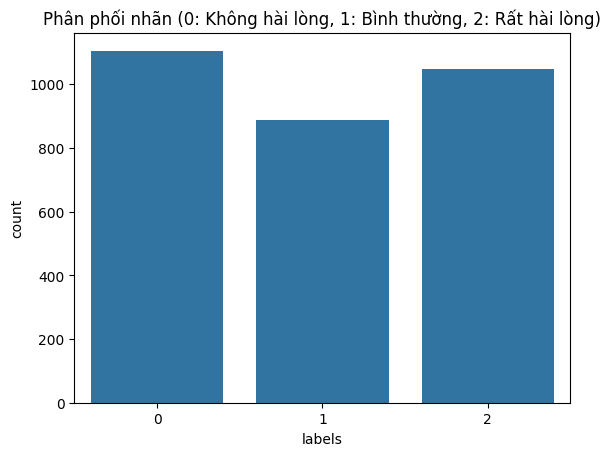

In [48]:
# %% [markdown]
# ## 2️⃣ Tải dữ liệu & xem trước
# Bạn có thể:
# - Tải trực tiếp từ Kaggle (nếu đã cấu hình API)
# - Hoặc upload file `train.csv` vào Colab (menu bên trái -> Files -> Upload)

# %%
# Nếu đã tải file thủ công
df = pd.read_csv("./data/tuannguyenvananh/vietnamese-text-classification-dataset/train.csv", names=["labels", "text"], header=None)

print("📄 5 dòng đầu:")
display(df.head())

print("\n🔍 Phân phối nhãn:")
print(df['labels'].value_counts())

sns.countplot(data=df, x='labels')
plt.title("Phân phối nhãn (0: Không hài lòng, 1: Bình thường, 2: Rất hài lòng)")
plt.show()


### Làm sạch và tách từ tiếng Việt

In [49]:
# %% [markdown]
# ## 3️⃣ Tiền xử lý dữ liệu tiếng Việt

# %%
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)     # bỏ link
    text = re.sub(r"[^a-zA-ZÀ-ỹ0-9\s]", " ", text)          # bỏ ký tự đặc biệt
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean_text'] = df['text'].apply(clean_text)
df['clean_text'] = df['clean_text'].apply(lambda x: word_tokenize(x, format="text"))
display(df[['labels', 'clean_text']].head())

# Tách train/test
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['labels'], test_size=0.2, stratify=df['labels'], random_state=42
)
print(f"Tập train: {len(X_train)}, test: {len(X_test)}")


,labels,clean_text
0,0,máy dùng hay bị đơ máy
1,0,chỉ có dây_cáp nguồn không có adapter sao sử_d...
2,0,chất_lượng quá kém mới dùng được 2 ngày loa ba...
3,0,usb tôi vừa_mới nhận usb này rất bực_bội vì cá...
4,2,tuyệt_vời hàng fpt cửa_hàng


Tập train: 2432, test: 608


### Huấn luyện RNN (LSTM)

In [55]:
# %% [markdown]
# ## 4️⃣ Xây dựng mô hình RNN (LSTM) — không dùng torchtext

# %%
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import re
from tqdm.auto import tqdm

# ===== Tiền xử lý & tách từ =====
def simple_tokenizer(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-ZÀ-ỹ0-9\s]', '', text)
    return text.split()

# Xây từ điển (vocab)
def build_vocab(texts, min_freq=1):
    word_freq = {}
    for text in texts:
        for tok in simple_tokenizer(text):
            word_freq[tok] = word_freq.get(tok, 0) + 1
    vocab = {"<pad>": 0, "<unk>": 1}
    for word, freq in word_freq.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

vocab = build_vocab(X_train)
print(f"Tổng số từ trong vocab: {len(vocab)}")

def encode_text(text, vocab):
    tokens = simple_tokenizer(text)
    return [vocab.get(tok, vocab["<unk>"]) for tok in tokens]

# ===== Dataset =====
class CommentDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.texts = list(texts)
        self.labels = list(labels)
        self.vocab = vocab

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        x = torch.tensor(encode_text(self.texts[idx], self.vocab), dtype=torch.long)
        y = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return x, y

def collate_batch(batch):
    texts, labels = zip(*batch)
    texts = nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=0)
    labels = torch.tensor(labels)
    return texts, labels

train_ds = CommentDataset(X_train, y_train, vocab)
test_ds = CommentDataset(X_test, y_test, vocab)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_batch)
test_dl = DataLoader(test_ds, batch_size=32, collate_fn=collate_batch)

# ===== Mô hình LSTM =====
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        emb = self.embedding(x)
        _, (h, _) = self.lstm(emb)
        return self.fc(h[-1])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_rnn = RNNClassifier(len(vocab), 100, 128, 3).to(device)
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# ===== Huấn luyện =====
EPOCHS = 10
for epoch in range(EPOCHS):
    model_rnn.train()
    total_loss = 0
    for Xb, yb in tqdm(train_dl, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model_rnn(Xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"✅ Epoch {epoch+1}: Loss = {total_loss/len(train_dl):.4f}")


Tổng số từ trong vocab: 4389


Epoch 1/10: 100%|██████████| 76/76 [00:00<00:00, 560.77it/s]


✅ Epoch 1: Loss = 1.0974


Epoch 2/10: 100%|██████████| 76/76 [00:00<00:00, 527.95it/s]


✅ Epoch 2: Loss = 1.0913


Epoch 3/10: 100%|██████████| 76/76 [00:00<00:00, 592.72it/s]


✅ Epoch 3: Loss = 1.0874


Epoch 4/10: 100%|██████████| 76/76 [00:00<00:00, 674.40it/s]


✅ Epoch 4: Loss = 1.0843


Epoch 5/10: 100%|██████████| 76/76 [00:00<00:00, 618.40it/s]


✅ Epoch 5: Loss = 1.1259


Epoch 6/10: 100%|██████████| 76/76 [00:00<00:00, 697.33it/s]


✅ Epoch 6: Loss = 1.0821


Epoch 7/10: 100%|██████████| 76/76 [00:00<00:00, 707.32it/s]


✅ Epoch 7: Loss = 1.0798


Epoch 8/10: 100%|██████████| 76/76 [00:00<00:00, 695.50it/s]


✅ Epoch 8: Loss = 1.0754


Epoch 9/10: 100%|██████████| 76/76 [00:00<00:00, 706.86it/s]


✅ Epoch 9: Loss = 1.0720


Epoch 10/10: 100%|██████████| 76/76 [00:00<00:00, 697.52it/s]

✅ Epoch 10: Loss = 1.0688


### Đánh giá RNN

🎯 Accuracy RNN: 0.37
              precision    recall  f1-score   support

           0       0.37      1.00      0.54       221
           1       0.80      0.02      0.04       177
           2       0.33      0.00      0.01       210

    accuracy                           0.37       608
   macro avg       0.50      0.34      0.20       608
weighted avg       0.48      0.37      0.21       608



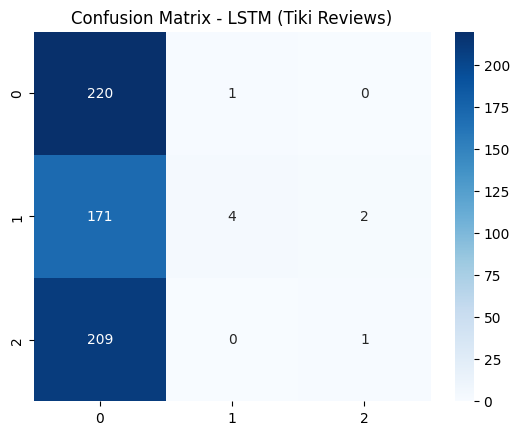

In [56]:
# %%
y_true_rnn, y_pred_rnn = [], []
model_rnn.eval()
with torch.no_grad():
    for Xb, yb in test_dl:
        Xb = Xb.to(device)
        preds = model_rnn(Xb)
        preds = preds.argmax(1).cpu().numpy()
        y_pred_rnn.extend(preds)
        y_true_rnn.extend(yb.numpy())

rnn_acc = accuracy_score(y_true_rnn, y_pred_rnn)
print("🎯 Accuracy RNN:", round(rnn_acc, 3))
print(classification_report(y_true_rnn, y_pred_rnn))

sns.heatmap(confusion_matrix(y_true_rnn, y_pred_rnn), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - LSTM (Tiki Reviews)")
plt.show()
